<a href="https://colab.research.google.com/github/gkuch22/ml-final/blob/main/final_model_experiment_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)


Device available:  cpu


In [283]:
train_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/train.csv')
stores_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/stores.csv')
features_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/features.csv')

In [284]:
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [285]:
stores_df.head(10)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [286]:
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


#DATA MERGE

In [287]:
features_df = features_df.drop(columns=["IsHoliday"])

In [288]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [289]:
merged_df = pd.merge(train_df, features_df, on=['Store', 'Date'], how='left')
merged_df = pd.merge(merged_df, stores_df, on='Store', how='left')

In [290]:
train_df.shape, stores_df.shape, features_df.shape, merged_df.shape

((421570, 5), (45, 3), (8190, 11), (421570, 16))

In [291]:
merged_df = merged_df.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

In [292]:
merged_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


#DATA ANALYSIS

In [293]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [294]:
print(merged_df.describe())

               Store           Dept                           Date  \
count  421570.000000  421570.000000                         421570   
mean       22.200546      44.260317  2011-06-18 08:30:31.963375104   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-10-08 00:00:00   
50%        22.000000      37.000000            2011-06-17 00:00:00   
75%        33.000000      74.000000            2012-02-24 00:00:00   
max        45.000000      99.000000            2012-10-26 00:00:00   
std        12.785297      30.492054                            NaN   

        Weekly_Sales    Temperature     Fuel_Price      MarkDown1  \
count  421570.000000  421570.000000  421570.000000  150681.000000   
mean    15981.258123      60.090059       3.361027    7246.420196   
min     -4988.940000      -2.060000       2.472000       0.270000   
25%      2079.650000      46.680000       2.933000    2240.270000   
50%      7612.030000    

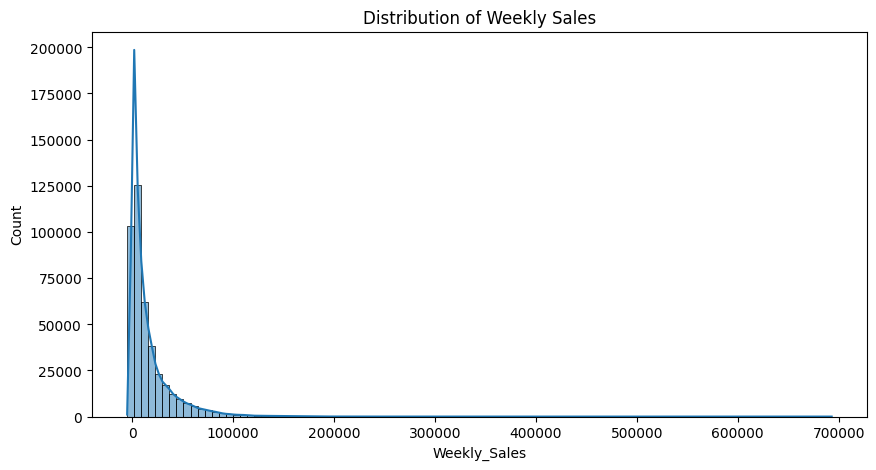

In [295]:
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['Weekly_Sales'], bins=100, kde=True)
plt.title("Distribution of Weekly Sales")
plt.show()

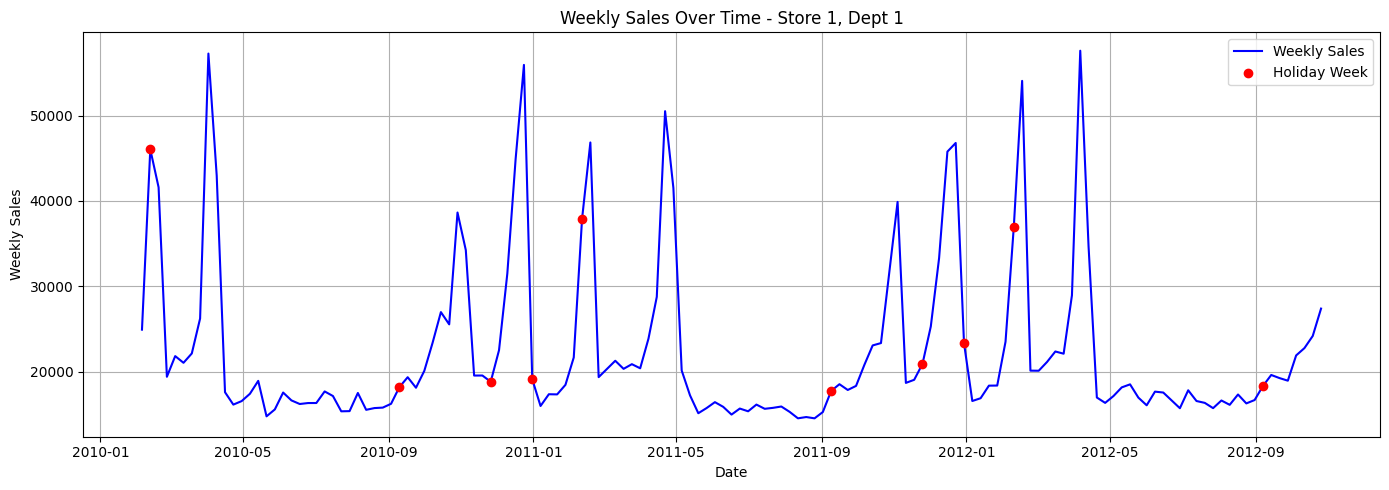

In [296]:
store_id = 1
dept_id = 1
subset = merged_df[(merged_df['Store'] == store_id) & (merged_df['Dept'] == dept_id)]

subset = subset.sort_values('Date')

plt.figure(figsize=(14, 5))
plt.plot(subset['Date'], subset['Weekly_Sales'], label='Weekly Sales', color='blue')

holiday_dates = subset[subset['IsHoliday'] == True]['Date']
holiday_sales = subset[subset['IsHoliday'] == True]['Weekly_Sales']
plt.scatter(holiday_dates, holiday_sales, color='red', label='Holiday Week', zorder=5)

plt.title(f"Weekly Sales Over Time - Store {store_id}, Dept {dept_id}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


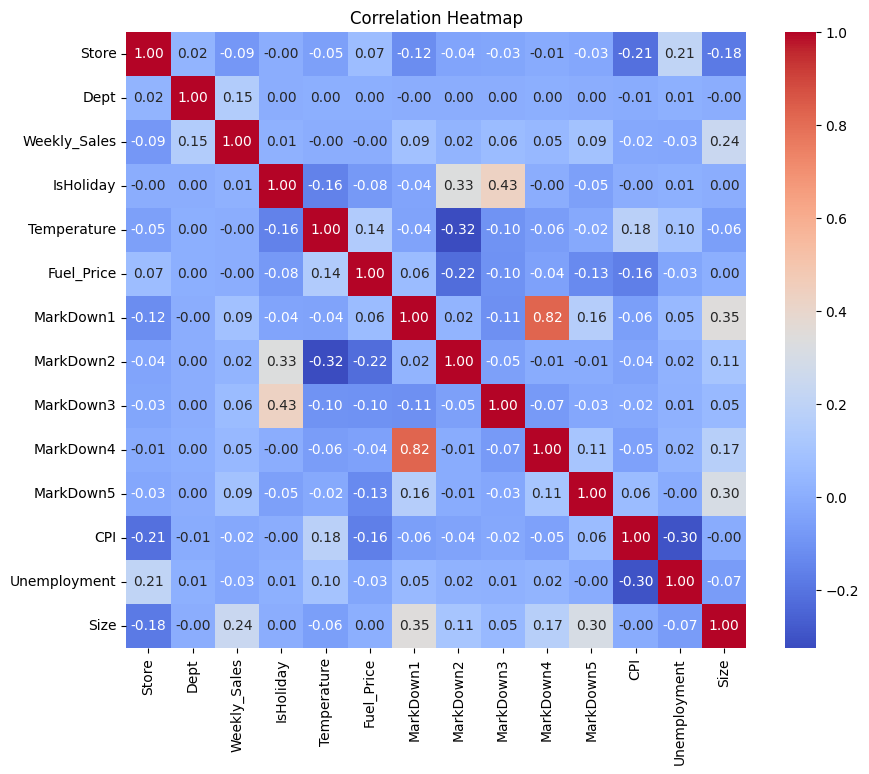

In [297]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

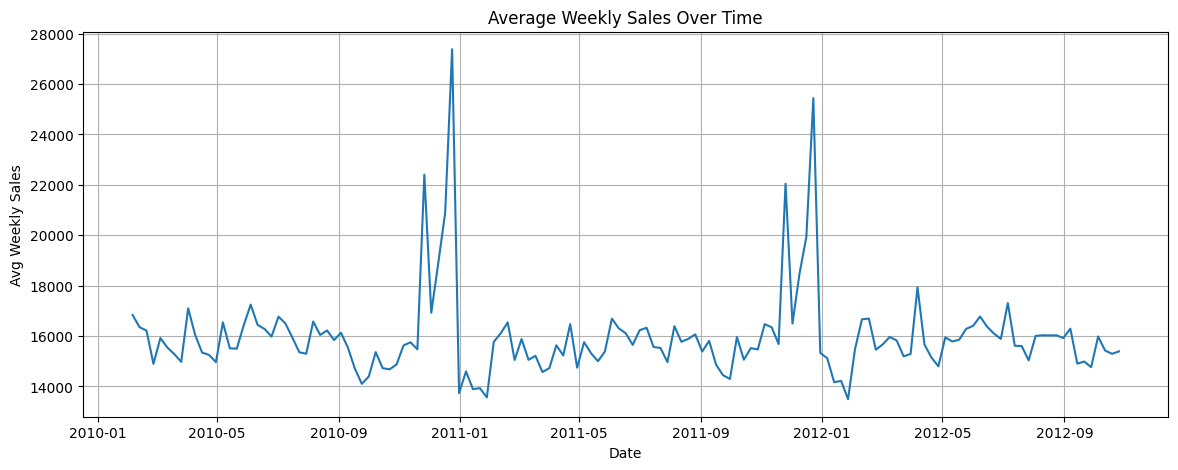

In [298]:
weekly_trend = merged_df.groupby('Date')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(weekly_trend['Date'], weekly_trend['Weekly_Sales'])
plt.title("Average Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Weekly Sales")
plt.grid(True)
plt.show()

In [299]:
holiday_effect = merged_df.groupby(['Store', 'IsHoliday'])['Weekly_Sales'].mean().unstack()
holiday_effect['Diff'] = holiday_effect[True] - holiday_effect[False]
holiday_effect = holiday_effect.sort_values('Diff', ascending=False)

print("stores with biggest sales diffs during holidays:\n", holiday_effect.head())

stores with biggest sales diffs during holidays:
 IsHoliday         False          True         Diff
Store                                             
10         26116.166656  29195.524157  3079.357501
35         13631.736739  16083.060734  2451.323994
28         18567.759341  20645.874372  2078.115030
2          26753.864227  28798.710526  2044.846300
12         14731.304140  16663.842167  1932.538027


In [300]:
dept_holiday_effect = merged_df.groupby(['Store', 'Dept', 'IsHoliday'])['Weekly_Sales'].mean().unstack()
dept_holiday_effect['Diff'] = dept_holiday_effect[True] - dept_holiday_effect[False]
dept_holiday_effect = dept_holiday_effect.sort_values('Diff', ascending=False)

print("depts with biggest sales diffs during holidays:\n", dept_holiday_effect.head())

depts with biggest sales diffs during holidays:
 IsHoliday           False        True           Diff
Store Dept                                          
10    72    133655.372331  263476.204  129820.831669
35    72     79364.480977  207597.270  128232.789023
20    72     86204.361278  168937.039   82732.677722
14    72     88897.642707  163875.262   74977.619293
27    72     63291.527368  138169.739   74878.211632


# FEATURE ENGINEERING

In [301]:
new_year_dates = ['2010-12-31', '2011-12-30']
merged_df['WeeksToNewYear'] = 0

for date_str in new_year_dates:
    event_date = pd.to_datetime(date_str)
    for i in range(1, 4):
        shifted_date = event_date - pd.Timedelta(weeks=i)
        condition = merged_df['Date'] == shifted_date
        column = 'WeeksToNewYear'
        merged_df.loc[condition, column] = i

In [302]:
holiday_lift = holiday_effect['Diff']
merged_df['StoreHolidayLift'] = merged_df['Store'].map(holiday_lift)

In [303]:
dept_holiday_lift = holiday_effect['Diff']
merged_df['DeptHolidayLift'] = merged_df.set_index(['Store', 'Dept']).index.map(dept_holiday_lift)
merged_df['DeptHolidayLift'] = merged_df['DeptHolidayLift'].fillna(0)

In [268]:
merged_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,WeeksToNewYear,StoreHolidayLift,DeptHolidayLift
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0,1429.751934,0.0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,0,1429.751934,0.0
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,0,1429.751934,0.0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,0,1429.751934,0.0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,0,1429.751934,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,0,683.788715,0.0
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221,0,683.788715,0.0
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221,0,683.788715,0.0
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221,0,683.788715,0.0


In [ ]:
merged_df['HolidayLag1'] = (merged_df.groupby(['Store', 'Dept'])['IsHoliday'].shift(1).fillna(False).astype(int))
merged_df['HolidayLag2'] = (merged_df.groupby(['Store', 'Dept'])['IsHoliday'].shift(2).fillna(False).astype(int))

/tmp/ipython-input-21-3803478995.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['HolidayLag1'] = (merged_df.groupby(['Store', 'Dept'])['IsHoliday'].shift(1).fillna(False).astype(int))
/tmp/ipython-input-21-3803478995.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['HolidayLag2'] = (merged_df.groupby(['Store', 'Dept'])['IsHoliday'].shift(2).fillna(False).astype(int))


In [ ]:
merged_df['SalesLag1'] = (merged_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1))
merged_df['SalesLag2'] = (merged_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2))
merged_df['SalesLag4'] = (merged_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4))

In [ ]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


# DATA PREPROCESSING

In [305]:
merged_df['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [306]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_type = onehot_encoder.fit_transform(merged_df[['Type']])
encoded_cols = onehot_encoder.get_feature_names_out(['Type'])
encoded_df = pd.DataFrame(encoded_type, columns=encoded_cols, index=merged_df.index)

merged_df = merged_df.drop(columns='Type')
merged_df = pd.concat([merged_df, encoded_df], axis=1)

In [307]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             421570 non-null  int64         
 1   Dept              421570 non-null  int64         
 2   Date              421570 non-null  datetime64[ns]
 3   Weekly_Sales      421570 non-null  float64       
 4   IsHoliday         421570 non-null  bool          
 5   Temperature       421570 non-null  float64       
 6   Fuel_Price        421570 non-null  float64       
 7   MarkDown1         150681 non-null  float64       
 8   MarkDown2         111248 non-null  float64       
 9   MarkDown3         137091 non-null  float64       
 10  MarkDown4         134967 non-null  float64       
 11  MarkDown5         151432 non-null  float64       
 12  CPI               421570 non-null  float64       
 13  Unemployment      421570 non-null  float64       
 14  Size

In [308]:
from sklearn.impute import SimpleImputer

na_cols = [col for col in merged_df.columns if merged_df[col].isna().sum() > 0]
imputer = SimpleImputer(strategy='mean')
merged_df[na_cols] = imputer.fit_transform(merged_df[na_cols])

In [309]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             421570 non-null  int64         
 1   Dept              421570 non-null  int64         
 2   Date              421570 non-null  datetime64[ns]
 3   Weekly_Sales      421570 non-null  float64       
 4   IsHoliday         421570 non-null  bool          
 5   Temperature       421570 non-null  float64       
 6   Fuel_Price        421570 non-null  float64       
 7   MarkDown1         421570 non-null  float64       
 8   MarkDown2         421570 non-null  float64       
 9   MarkDown3         421570 non-null  float64       
 10  MarkDown4         421570 non-null  float64       
 11  MarkDown5         421570 non-null  float64       
 12  CPI               421570 non-null  float64       
 13  Unemployment      421570 non-null  float64       
 14  Size

In [310]:
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Week'] = merged_df['Date'].dt.isocalendar().week.astype(int)

merged_df = merged_df.drop(columns=['Date'])

In [311]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Store             421570 non-null  int64  
 1   Dept              421570 non-null  int64  
 2   Weekly_Sales      421570 non-null  float64
 3   IsHoliday         421570 non-null  bool   
 4   Temperature       421570 non-null  float64
 5   Fuel_Price        421570 non-null  float64
 6   MarkDown1         421570 non-null  float64
 7   MarkDown2         421570 non-null  float64
 8   MarkDown3         421570 non-null  float64
 9   MarkDown4         421570 non-null  float64
 10  MarkDown5         421570 non-null  float64
 11  CPI               421570 non-null  float64
 12  Unemployment      421570 non-null  float64
 13  Size              421570 non-null  int64  
 14  WeeksToNewYear    421570 non-null  int64  
 15  StoreHolidayLift  421570 non-null  float64
 16  DeptHolidayLift   42

In [312]:
merged_df

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,WeeksToNewYear,StoreHolidayLift,DeptHolidayLift,Type_A,Type_B,Type_C,Year,Month,Week
0,1,1,24924.50,False,42.31,2.572,7246.420196,3334.628621,1439.421384,3383.168256,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,2,5
1,1,1,46039.49,True,38.51,2.548,7246.420196,3334.628621,1439.421384,3383.168256,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,2,6
2,1,1,41595.55,False,39.93,2.514,7246.420196,3334.628621,1439.421384,3383.168256,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,2,7
3,1,1,19403.54,False,46.63,2.561,7246.420196,3334.628621,1439.421384,3383.168256,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,2,8
4,1,1,21827.90,False,46.50,2.625,7246.420196,3334.628621,1439.421384,3383.168256,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,508.37,False,64.88,3.997,4556.610000,20.640000,1.500000,1601.010000,...,118221,0,0.266042,0.0,0.0,1.0,0.0,2012,9,39
421566,45,98,628.10,False,64.89,3.985,5046.740000,3334.628621,18.820000,2253.430000,...,118221,0,0.266042,0.0,0.0,1.0,0.0,2012,10,40
421567,45,98,1061.02,False,54.47,4.000,1956.280000,3334.628621,7.890000,599.320000,...,118221,0,0.266042,0.0,0.0,1.0,0.0,2012,10,41
421568,45,98,760.01,False,56.47,3.969,2004.020000,3334.628621,3.180000,437.730000,...,118221,0,0.266042,0.0,0.0,1.0,0.0,2012,10,42


# DATA SPLIT

In [313]:
year_split = 2012
month_split = 6

train_df = merged_df[merged_df['Year'] < year_split]
valid_df = merged_df[(merged_df['Year'] == year_split) & (merged_df['Month'] < month_split)]
test_df = merged_df[(merged_df['Year'] == year_split) & (merged_df['Month'] >= month_split)]

In [314]:
y_train = train_df['Weekly_Sales']
X_train = train_df.drop(columns='Weekly_Sales')

y_valid = valid_df['Weekly_Sales']
X_valid = valid_df.drop(columns='Weekly_Sales')

y_test = test_df['Weekly_Sales']
X_test = test_df.drop(columns='Weekly_Sales')

In [315]:
merged_df.shape, X_train.shape, X_valid.shape, X_test.shape

((421570, 23), (294132, 22), (62357, 22), (65081, 22))

In [316]:
X_train

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Size,WeeksToNewYear,StoreHolidayLift,DeptHolidayLift,Type_A,Type_B,Type_C,Year,Month,Week
0,1,1,False,42.31,2.572,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,2,5
1,1,1,True,38.51,2.548,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,2,6
2,1,1,False,39.93,2.514,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,2,7
3,1,1,False,46.63,2.561,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,2,8
4,1,1,False,46.50,2.625,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,...,151315,0,0.494591,0.0,1.0,0.0,0.0,2010,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421522,45,98,False,50.19,3.452,6835.610000,120.760000,802.790000,2490.150000,17861.500000,...,118221,0,0.266042,0.0,0.0,1.0,0.0,2011,12,48
421523,45,98,False,46.57,3.415,6176.690000,2.870000,379.570000,1593.440000,10170.500000,...,118221,3,0.266042,0.0,0.0,1.0,0.0,2011,12,49
421524,45,98,False,39.93,3.413,4631.260000,8.920000,801.340000,848.330000,2757.820000,...,118221,2,0.266042,0.0,0.0,1.0,0.0,2011,12,50
421525,45,98,False,42.27,3.389,797.100000,89.140000,1962.190000,17.000000,2985.510000,...,118221,1,0.266042,0.0,0.0,1.0,0.0,2011,12,51


# MODEL TRAINING

In [317]:
def get_wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

train wmae: 7281.95
valid wmae: 7091.00



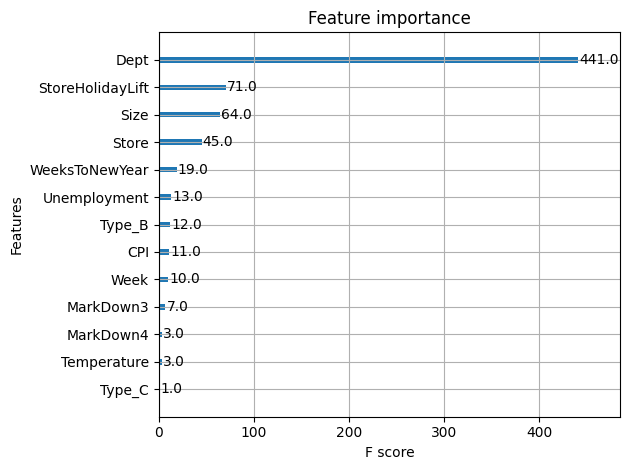

In [318]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

weights_train = np.where(X_train['IsHoliday'], 5, 1)
weights_valid = np.where(X_valid['IsHoliday'], 5, 1)

train_score = get_wmae(y_train.values, y_pred_train, weights_train)
valid_score = get_wmae(y_valid.values, y_pred_valid, weights_valid)

print(f"train wmae: {train_score:.2f}")
print(f"valid wmae: {valid_score:.2f}")
print()

xgb.plot_importance(model)
plt.tight_layout()


# MLFLOW TRACKING

In [166]:
!pip install dagshub mlflow -q

In [167]:
import dagshub
import mlflow

dagshub.init(repo_owner='gkuch22', repo_name='ml-final', mlflow=True)

Initialized MLflow to track repo "gkuch22/ml-final"

Repository gkuch22/ml-final initialized!

In [168]:
experiment_name = "XGBoost_train"
run_name = "onehot_weekstonewyear"

train wmae: 7135.05
valid wmae: 6833.34
🏃 View run onehot_weekstonewyear at: https://dagshub.com/gkuch22/ml-final.mlflow/#/experiments/2/runs/4d72ce1d0195442db55fdf1c8a8e0d98
🧪 View experiment at: https://dagshub.com/gkuch22/ml-final.mlflow/#/experiments/2


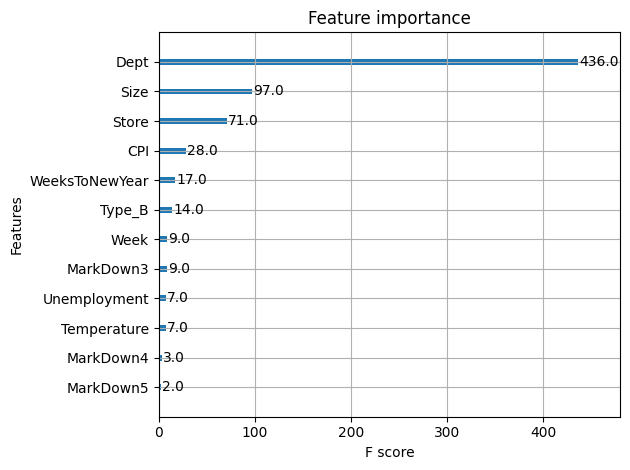

In [169]:
import mlflow
import xgboost as xgb

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):

    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 3)
    mlflow.log_param("reg_lambda", 1.0)
    mlflow.log_param("data", "merged")
    mlflow.log_param("num_features", X_train.shape[1])

    mlflow.log_param("model_type", "XGBoost")

    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        verbosity=1
    )

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    weights_train = np.where(X_train['IsHoliday'], 5, 1)
    weights_valid = np.where(X_valid['IsHoliday'], 5, 1)

    train_wmae = get_wmae(y_train.values, y_pred_train, weights_train)
    valid_wmae = get_wmae(y_valid.values, y_pred_valid, weights_valid)

    print(f"train wmae: {train_wmae:.2f}")
    print(f"valid wmae: {valid_wmae:.2f}")

    mlflow.log_metric("train_wmae", train_wmae)
    mlflow.log_metric("valid_wmae", valid_wmae)

    # mlflow.sklearn.log_model(model, "model")

    xgb.plot_importance(model)
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")
